# Validation of the Composite IGATP

In this notebook we validate the **Composite Index of Perceived Touristic Attractiveness (IGATP)** through four analyses:
1. Internal Correlation
2. Sensitivity to Weighting Schemes
3. Stability under Low-Review Filter
4. Distribution of Composite Index (IGATP)
5. 95 % Bootstrap Confidence Interval for Pearson’s r
6. Validation of Clustering Structure
7. Sentiment Polarity vs Star Ratings – Visual Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean, var
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import pearsonr
from libpysal.weights import Queen
from esda.moran import Moran

In [3]:
composite_index = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/6_unsupervised_learning/composite_index_with_clusters.csv")
df = pd.read_csv("C:/Users/Fernanda Costa/OneDrive - Universidade de Aveiro/Desktop/seminar_project/6_unsupervised_learning/ratings_polarity_lda_topics.csv")

## Internal Correlation

Assess the relationship between the Bayesian-adjusted rating and average sentiment.

In [4]:
# Select only the two columns we care about
cols = ["Rating_Bayes_norm", "Sentiment_norm"]
sub = composite_index[cols].copy()

# Drop any rows with NaN or infinite values
mask = np.isfinite(sub).all(axis=1)
clean = sub[mask]

# Compute Pearson’s r on the cleaned data
r, p_value = pearsonr(clean["Rating_Bayes_norm"], clean["Sentiment_norm"])
print(f"Pearson’s r = {r:.2f}, p-value = {p_value:.3f}")

Pearson’s r = 0.27, p-value = 0.000


## Sensitivity to Weighting Schemes

Test how the IGATP ranking changes under alternative weight scenarios.

In [5]:
# Define weight scenarios
scenarios = {
    "equal"       : (1/3, 1/3, 1/3),
    "rating_heavy": (0.5, 0.25, 0.25),
    "pop_heavy"   : (0.25, 0.5, 0.25),
    "sent_heavy"  : (0.25, 0.25, 0.5),
}

correlations = {}
for name, (w1, w2, w3) in scenarios.items():
    # compute the alternative IGATP
    composite_index[name] = (
        w1 * composite_index["Rating_Bayes_norm"]
      + w2 * composite_index["Popularity_norm"]
      + w3 * composite_index["Sentiment_norm"]
    )
    if name != "equal":
        # keep only rows where both the equal-weight and this scenario are finite
        sub = composite_index[["equal", name]].dropna()
        r_alt, _ = pearsonr(sub["equal"], sub[name])
        correlations[name] = r_alt

print("Correlation with equal-weight IGATP:")
for scenario, r_val in correlations.items():
    print(f" • {scenario}: r = {r_val:.3f}")


Correlation with equal-weight IGATP:
 • rating_heavy: r = 0.968
 • pop_heavy: r = 0.980
 • sent_heavy: r = 0.968


## Stability under Low-Review Filter

Evaluate the impact of excluding POIs with fewer than 10 reviews.

In [6]:
# Create masks
mask_high = composite_index["Total_Reviews"] >= 10
mask_low  = composite_index["Total_Reviews"] <  10

# Extract the full‐dataset IGATP and the two subsets
ig_full = composite_index["IGATP"]
ig_high = composite_index.loc[mask_high, "IGATP"]
ig_low  = composite_index.loc[mask_low,  "IGATP"]

# Drop any NaNs (shouldn’t be any, but just in case)
ig_full_high = ig_full[mask_high].dropna()
ig_high      = ig_high.dropna()

ig_full_low  = ig_full[mask_low].dropna()
ig_low       = ig_low.dropna()

# Compute correlations
r_high, p_high = pearsonr(ig_full_high, ig_high)
r_low,  p_low  = pearsonr(ig_full_low,  ig_low)

print(f"Correlation (full vs ≥10 reviews): r = {r_high:.3f}, p = {p_high:.3f}")
print(f"Correlation (full vs <10 reviews) : r = {r_low:.3f}, p = {p_low:.3f}")

Correlation (full vs ≥10 reviews): r = 1.000, p = 0.000
Correlation (full vs <10 reviews) : r = 1.000, p = 0.000


## Distribution of Composite Index (IGATP)

To assess the overall shape, skewness and presence of outliers in our composite IGATP scores, we plot both a histogram (with KDE) and a violin plot. This gives an immediate sense of whether the index is roughly symmetric, multimodal or heavily tailed.


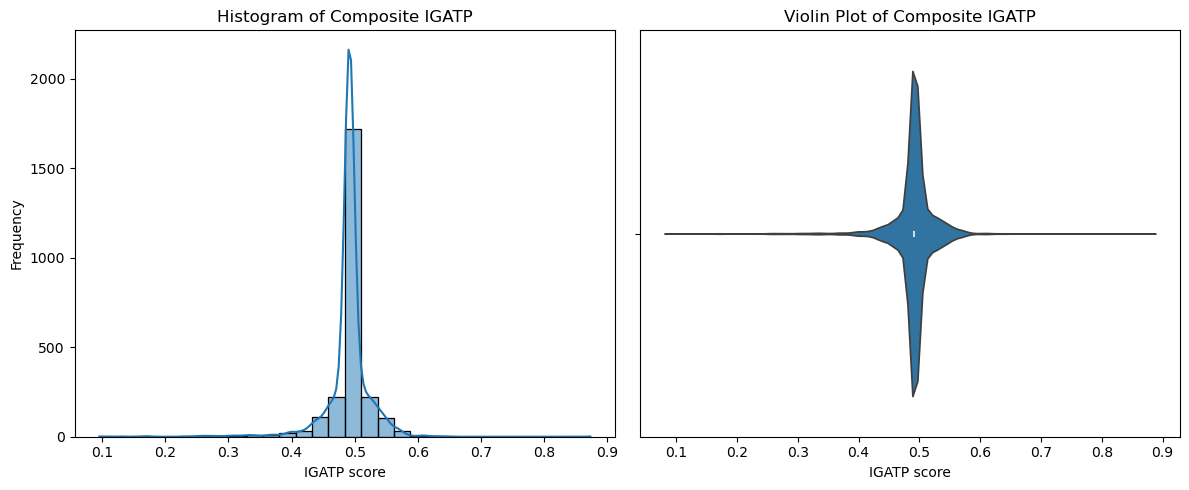

In [7]:
# ── Cell: Distribution of IGATP ──────────────────────────────────────────────
# assume `composite_index` is already loaded with a column 'IGATP'
igatp = composite_index['IGATP'].dropna()

plt.figure(figsize=(12,5))

# Histogram + KDE
plt.subplot(1,2,1)
sns.histplot(igatp, bins=30, kde=True)
plt.title('Histogram of Composite IGATP')
plt.xlabel('IGATP score')
plt.ylabel('Frequency')

# Violin plot
plt.subplot(1,2,2)
sns.violinplot(x=igatp)
plt.title('Violin Plot of Composite IGATP')
plt.xlabel('IGATP score')

plt.tight_layout()
plt.show()


## 95 % Bootstrap Confidence Interval for Pearson’s r

We now quantify the uncertainty around our observed Pearson correlation (r) between the Bayesian-adjusted rating and average sentiment polarity by performing 1 000 bootstrap resamples. The resulting 2.5th–97.5th percentile interval gives a non-parametric CI for r.

Observed Pearson’s r = 0.27
95% bootstrap CI for r: [0.19, 0.34]


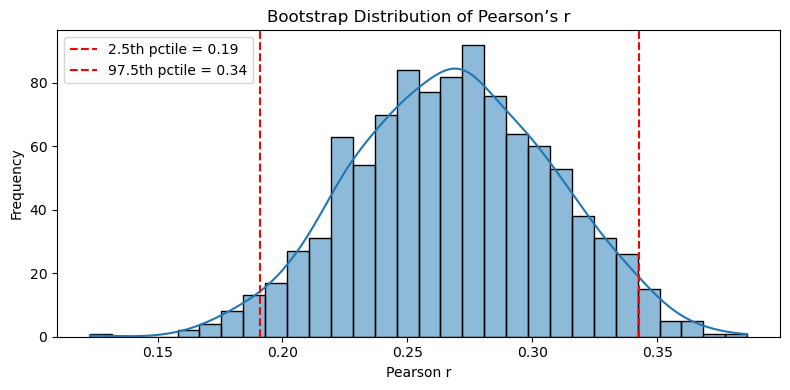

In [8]:
# prepare arrays, dropping any NaNs
x = composite_index['Rating_Bayes_norm']
y = composite_index['Sentiment_norm']
mask = x.notna() & y.notna()
x = x[mask].values
y = y[mask].values

# observed correlation
r_obs, p_obs = pearsonr(x, y)

# bootstrap
n_boot = 1000
rng = np.random.default_rng(42)
boot_r = []
for _ in range(n_boot):
    idx = rng.integers(0, len(x), len(x))
    r_i, _ = pearsonr(x[idx], y[idx])
    boot_r.append(r_i)

low, high = np.percentile(boot_r, [2.5, 97.5])

print(f"Observed Pearson’s r = {r_obs:.2f}")
print(f"95% bootstrap CI for r: [{low:.2f}, {high:.2f}]")

# plot the bootstrap distribution
plt.figure(figsize=(8,4))
sns.histplot(boot_r, bins=30, kde=True)
plt.axvline(low,  color='red', linestyle='--', label=f'2.5th pctile = {low:.2f}')
plt.axvline(high, color='red', linestyle='--', label=f'97.5th pctile = {high:.2f}')
plt.title('Bootstrap Distribution of Pearson’s r')
plt.xlabel('Pearson r')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


## Validation of Clustering Structure

To assess the quality of the clusters produced from the normalized sub-indices (`Rating_Bayes_norm`, `Popularity_norm`, `Sentiment_norm`), we compute the **Silhouette Score**.

This metric measures how similar each observation is to its own cluster compared to other clusters. It ranges from -1 to 1:
- **Values closer to 1** indicate well-separated and dense clusters.
- **Values near 0** suggest overlapping or indistinct clusters.
- **Negative values** imply possible misclassification.

A higher Silhouette Score supports the validity of the clustering structure adopted in the IGATP analysis.


In [11]:
# Feature matrix used for clustering (e.g., the normalized sub-indices)
X = composite_index[["Rating_Bayes_norm", "Popularity_norm", "Sentiment_norm"]].dropna()

# Cluster labels (e.g., 6-cluster solution)
labels = composite_index.loc[X.index, "cluster_k7_pam"]

# Silhouette score
score = silhouette_score(X, labels)
print(f"Silhouette Score for cluster k=7 (K-Medoids): {score:.3f}")

Silhouette Score for cluster k=7 (K-Medoids): 0.684


## Sentiment Polarity vs Star Ratings – Visual Analysis

The bar plot below shows the average sentiment polarity for each level of user rating (1★ to 5★).  
This analysis validates that the sentiment metric is aligned with star-based user satisfaction.

- 1★: clearly negative polarity
- 2★: nearly neutral
- 3★: moderately positive
- 4★: clearly positive
- 5★: strongly positive

### Interpretation:
> The steady increase in average sentiment polarity from 1★ to 5★ confirms the consistency of the NLP-based sentiment measure.  
> This further supports its reliability as a component of the IGATP index.

C:\Users\Fernanda Costa\AppData\Local\Temp\ipykernel_15900\3012349470.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_polarity.index, y=avg_polarity.values, palette="Blues_d")


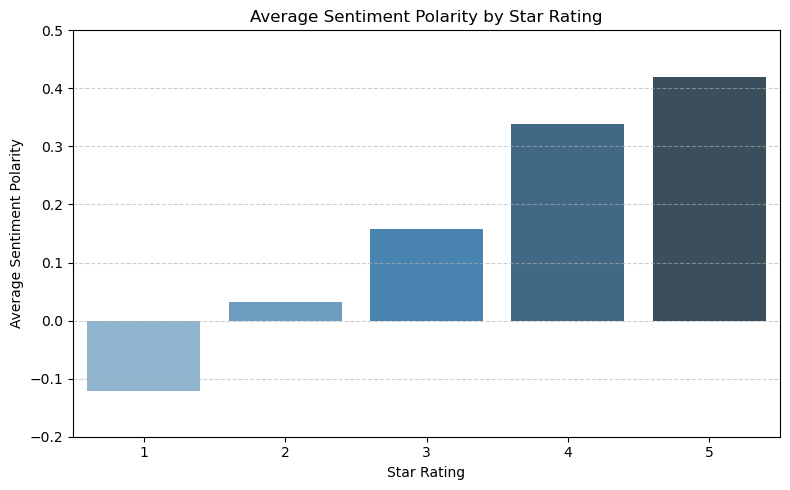

In [10]:
# Round star ratings and calculate average polarity
df["Star_Rating"] = df["Rating"].round().astype(int)
avg_polarity = df.groupby("Star_Rating")["Polaridade"].mean().sort_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_polarity.index, y=avg_polarity.values, palette="Blues_d")
plt.title("Average Sentiment Polarity by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Average Sentiment Polarity")
plt.ylim(-0.2, 0.5)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()